### DATA CLEANING - PRELIMINARY WORK

### 0. Setup & Config

In [1]:
# Spotify Audio Features — Cleaning, Thresholding & Graph Export

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

import scipy.sparse as sp
import networkx as nx

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

DATA_PATH = "dataset.csv"  
OUT_DIR = Path("data_clean")
OUT_DIR.mkdir(exist_ok=True, parents=True)

### 1. Load Raw Data & Overview

In [2]:
# Load raw data & basic overview

df_raw = pd.read_csv(DATA_PATH)

print("Raw shape:", df_raw.shape)
print("\nColumns:\n", df_raw.columns.tolist())

print("\nDtypes:\n", df_raw.dtypes)

print("\nMissing values per column:\n", df_raw.isna().sum())

# Show first few rows
df_raw.head()


Raw shape: (114000, 21)

Columns:
 ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']

Dtypes:
 Unnamed: 0            int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

Missing values per column:
 Unnamed: 0          0
track_id            0
arti

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


### 2. Deduplication & Cleaning

In [17]:

# Deduplication & audio feature cleaning

KEEP = [
    "danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness", "valence", "tempo"
]

df = df_raw.copy()
print("Starting from:", df.shape)

# Deduplicate on track_id, keeping highest popularity ---
if "track_id" in df.columns:
    if "popularity" in df.columns:
        df = df.sort_values("popularity", ascending=False)
    before = df.shape[0]
    # df = df.drop_duplicates(subset=["track_name"], keep="first")
    df = df.drop_duplicates(subset=["track_id"], keep="first")

    print(f"After track_id dedupe: {df.shape} (removed {before - df.shape[0]})")

# Fallback dedupe on normalized (artists, track_name, album_name) ---
import re

def norm_text(s):
    s = str(s).lower()
    s = re.sub(r"[^\w\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

for col in ["artists", "track_name", "album_name"]:
    if col in df.columns:
        df[f"norm_{col}"] = df[col].map(norm_text)

keys = [c for c in ["norm_artists", "norm_track_name", "norm_album_name"] if c in df.columns]
if keys:
    before = df.shape[0]
    df = df.drop_duplicates(subset=keys, keep="first")
    print(f"After fallback dedupe: {df.shape} (removed {before - df.shape[0]})")

# Drop helper cols
df = df.drop(columns=[c for c in df.columns if c.startswith("norm_")])

print("\nShape after deduplication:", df.shape)




Starting from: (114000, 21)
After track_id dedupe: (89741, 21) (removed 24259)
After fallback dedupe: (89353, 24) (removed 388)

Shape after deduplication: (89353, 21)


In [18]:
# How many track_names appear with multiple different track_ids? 
name_counts = df.groupby('track_name')['track_id'].nunique() 
print(f"Unique track names: {len(name_counts)}") 
print(f"Names with multiple track_ids: {(name_counts > 1).sum()}") 
print(f"Distribution:\n{name_counts.value_counts().head(10)}")
 

Unique track names: 73593
Names with multiple track_ids: 7782
Distribution:
track_id
1     65811
2      5082
3      1304
4       498
5       294
6       161
7       112
8        72
9        53
10       46
Name: count, dtype: int64


### 3. Audio Feature Selection & Range Filtering

In [4]:
# Select & clean audio features

# Check that all KEEP columns exist
missing = [c for c in KEEP if c not in df.columns]
if missing:
    raise ValueError(f"Missing required audio feature columns: {missing}")

# Extract audio features
X = df[KEEP].copy()

# Coerce to numeric
X = X.apply(pd.to_numeric, errors="coerce")

print("Shape after selecting audio features:", X.shape)

# --- 3.1 Range sanity checks ---
bounded = [
    "danceability", "energy", "speechiness",
    "acousticness", "instrumentalness", "liveness", "valence"
]

before = X.shape[0]
for col in bounded:
    X = X[(X[col] >= 0.0) & (X[col] <= 1.0)]
print(f"Filtered {before - X.shape[0]} rows outside [0,1] for bounded features.")

before = X.shape[0]
X = X[(X["loudness"] >= -60.0) & (X["loudness"] <= 0.0)]
print(f"Filtered {before - X.shape[0]} rows by loudness range [-60, 0].")

before = X.shape[0]
X = X[(X["tempo"] > 0) & (X["tempo"] <= 250)]
print(f"Filtered {before - X.shape[0]} rows by tempo range (0, 250].")

# Align df to surviving rows
df = df.loc[X.index]

# Drop any remaining NaNs
before = X.shape[0]
X = X.dropna(axis=0, how="any")
df = df.loc[X.index]
print(f"Dropped {before - X.shape[0]} rows with NaNs.")

print("\nFinal cleaned audio feature matrix:", X.shape)
print(X.describe())


Shape after selecting audio features: (89353, 9)
Filtered 0 rows outside [0,1] for bounded features.
Filtered 68 rows by loudness range [-60, 0].
Filtered 154 rows by tempo range (0, 250].
Dropped 0 rows with NaNs.

Final cleaned audio feature matrix: (89131, 9)
       danceability        energy      loudness   speechiness  acousticness  \
count  89131.000000  89131.000000  89131.000000  89131.000000  89131.000000   
mean       0.563147      0.634993     -8.486216      0.087518      0.328569   
std        0.175249      0.255755      5.179552      0.113362      0.338307   
min        0.051300      0.000020    -46.591000      0.022100      0.000000   
25%        0.450000      0.458000    -10.313000      0.036000      0.017200   
50%        0.576000      0.677000     -7.183000      0.049000      0.188000   
75%        0.692000      0.853000     -5.109000      0.085800      0.626000   
max        0.985000      1.000000     -0.001000      0.965000      0.996000   

       instrumentalness  

### 4. Standardization

In [5]:
# Standardize features (z-score)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

X_std_df = pd.DataFrame(X_std, index=X.index, columns=KEEP)

print("Standardized matrix shape:", X_std_df.shape)
X_std_df.head()


Standardized matrix shape: (89131, 9)


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
81051,0.860795,-0.637307,0.214540,-0.009859,-0.932794,-0.534232,0.254209,-0.885808,0.298932
51664,0.330118,0.574798,0.567275,-0.383885,-0.934272,-0.432153,0.069039,0.303176,0.194959
89411,1.551244,0.172067,0.609557,-0.450928,0.752076,-0.534240,0.007316,1.446430,0.092164
81210,-0.012253,1.290331,0.929278,-0.469453,-0.959900,-0.534224,0.794289,-0.634292,0.195195
88407,0.495598,0.312827,0.634849,1.459783,-0.677699,-0.533346,-0.465897,-1.080161,-0.524268


### 5. Exploratory Plots (for the paper)

### 5.1 Histograms

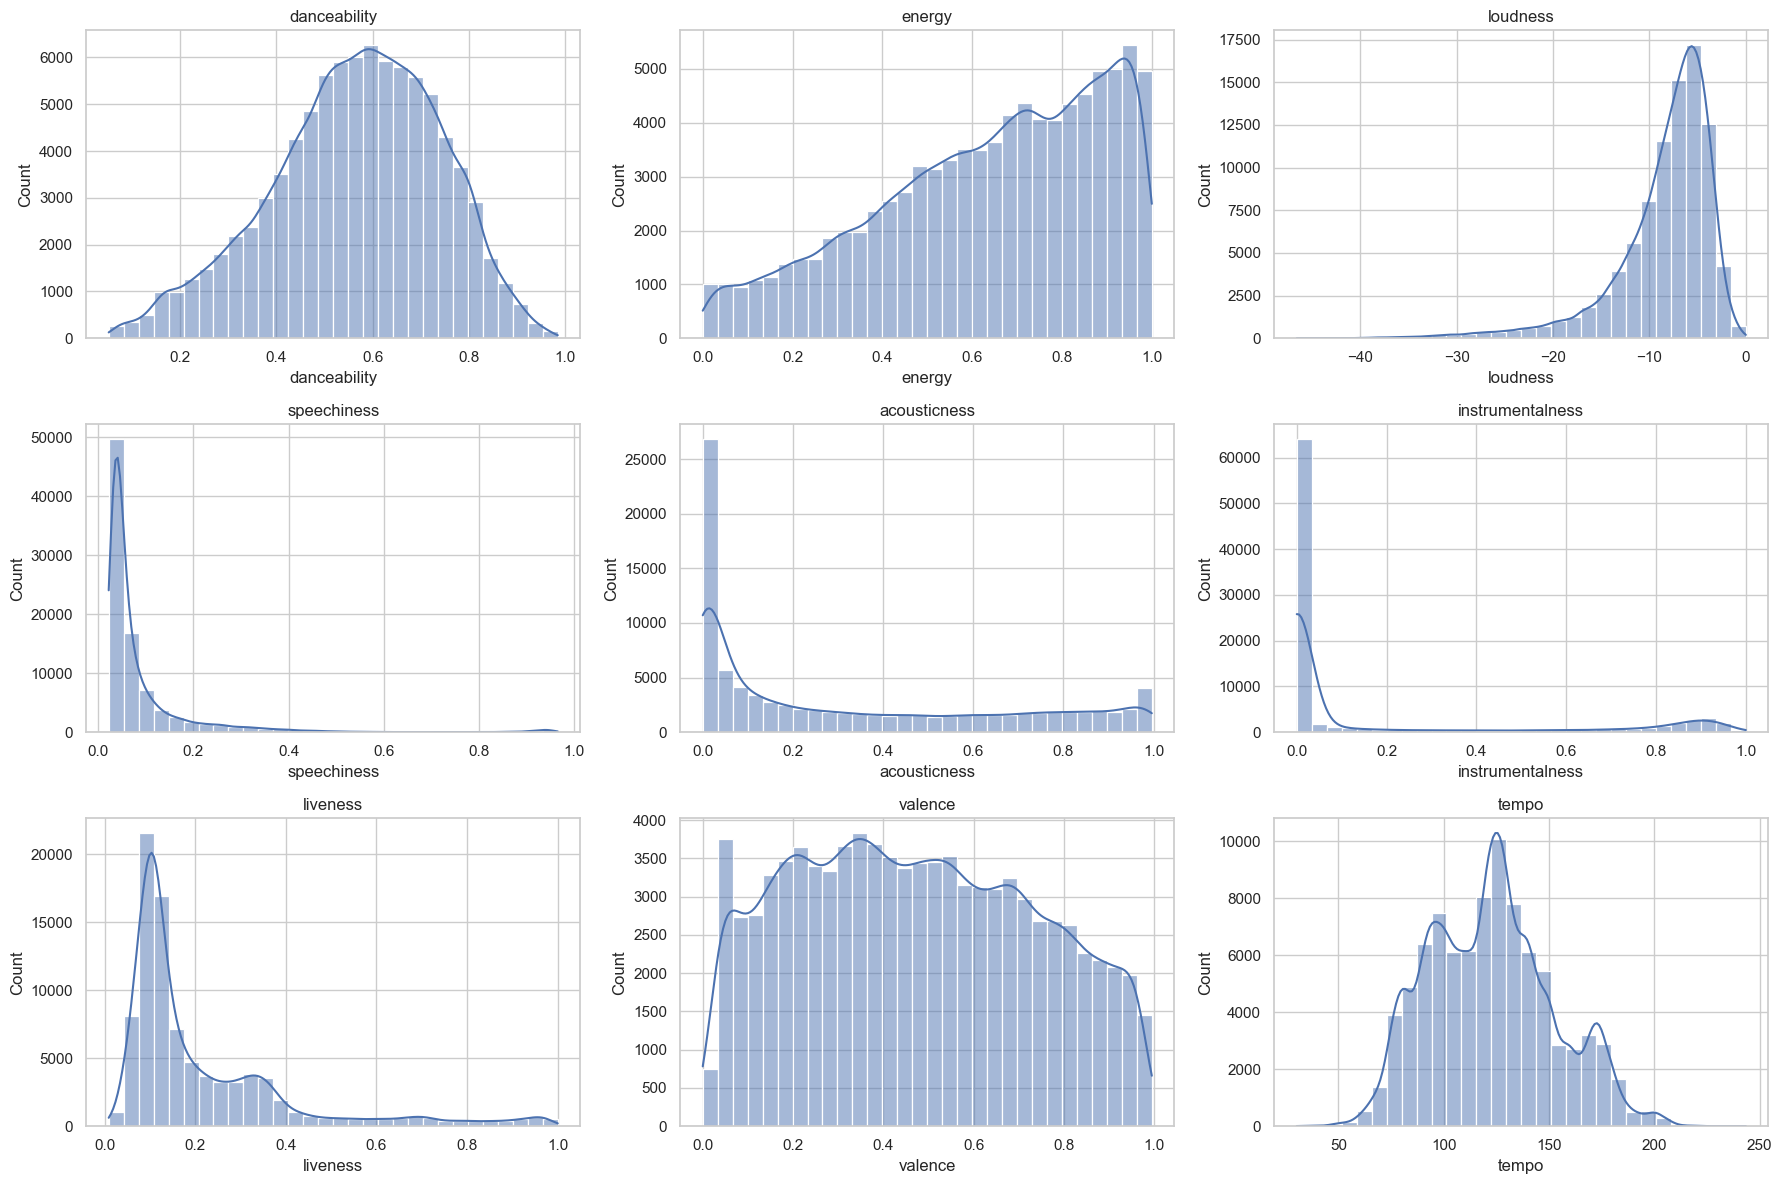

In [6]:
# Exploratory plots — distributions & correlations

plt.figure(figsize=(18, 12))
for i, col in enumerate(KEEP, 1):
    plt.subplot(3, 3, i)
    sns.histplot(X[col], bins=30, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()


### 5.2 Correlation Heatmap

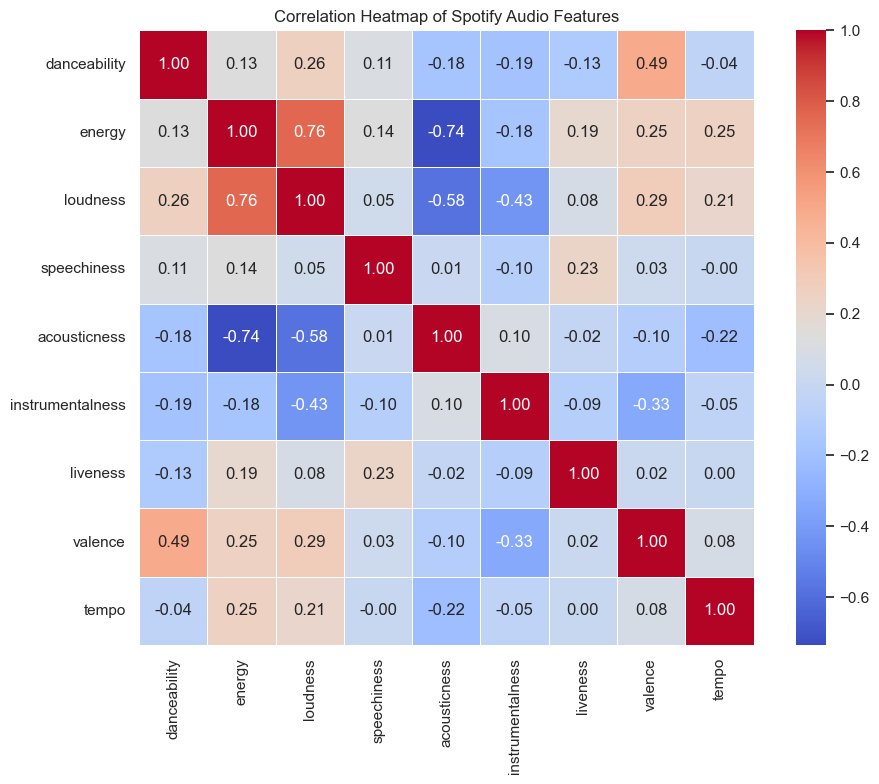

In [7]:
plt.figure(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Spotify Audio Features")
plt.tight_layout()
plt.show()


### 5.3 Top-20 Genre Distribution

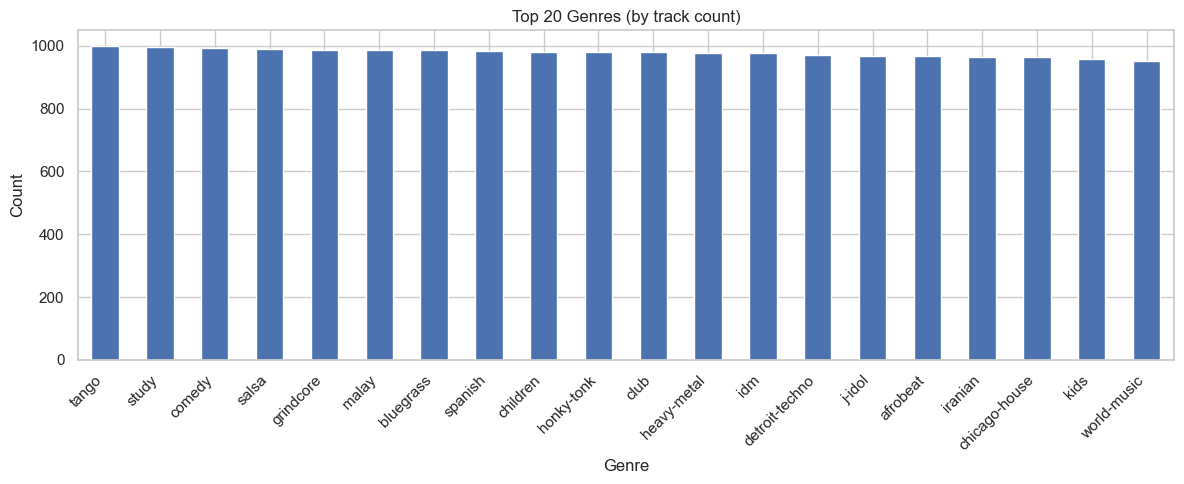

In [8]:
plt.figure(figsize=(12,5))
df["track_genre"].value_counts().head(20).plot(kind="bar")
plt.title("Top 20 Genres (by track count)")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### 6. PCA (Analysis + Plots)

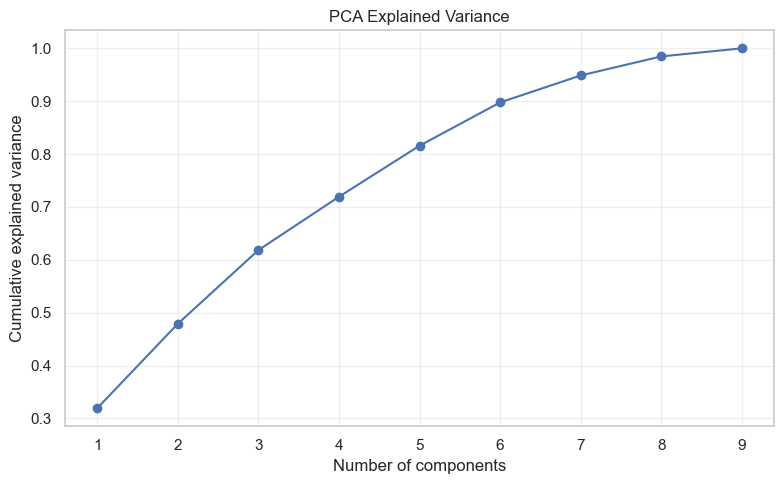

PCA(5) shape: (89131, 5)
Explained variance (5 components): 0.8157750424283883


In [9]:
# PCA — dimensionality reduction
# Full PCA to inspect explained variance
pca_full = PCA()
pca_full.fit(X_std_df)

cum_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_var)+1), cum_var, marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Explained Variance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Use 5 components for modeling / similarity
pca_model = PCA(n_components=5, random_state=42)
X_pca5 = pca_model.fit_transform(X_std_df)

print("PCA(5) shape:", X_pca5.shape)
print("Explained variance (5 components):", pca_model.explained_variance_ratio_.sum())


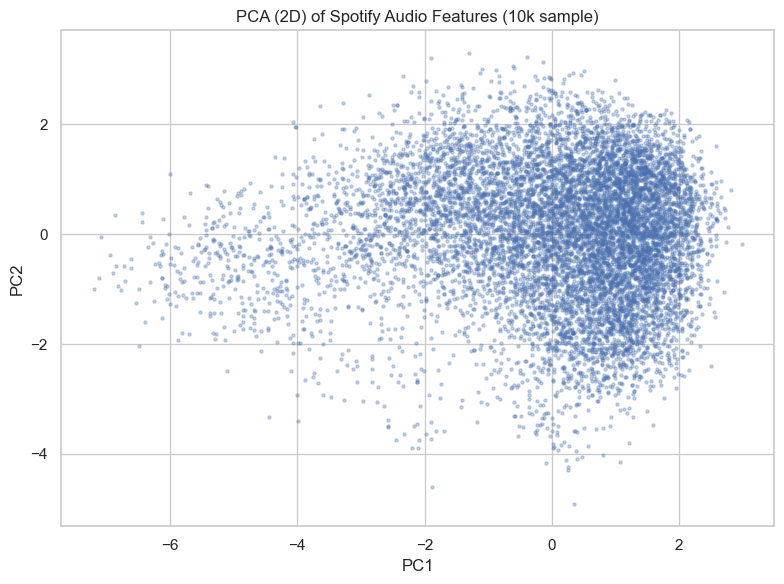

In [10]:
# 2D PCA just for visualization
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_std_df)

# sample points for plotting
np.random.seed(42)
idx_sample = np.random.choice(len(X_pca2), size=10000, replace=False)
plt.figure(figsize=(8,6))
plt.scatter(X_pca2[idx_sample, 0], X_pca2[idx_sample, 1], s=5, alpha=0.3)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (2D) of Spotify Audio Features (10k sample)")
plt.tight_layout()
plt.show()


### 7. Build Base kNN Structure in PCA Space

In [11]:
# 7. Base kNN structure in PCA space

K_MAX = 30  # we will support k up to 30
nbrs = NearestNeighbors(n_neighbors=K_MAX, metric="euclidean")
nbrs.fit(X_pca5)

distances, indices = nbrs.kneighbors(X_pca5)

# Convert distances to similarity (bounded, monotonic)
sims = 1 / (1 + distances)

print("indices shape:", indices.shape)
print("sims shape:", sims.shape)


KeyboardInterrupt: 

### 8. Thresholding Methods — 3 Variants

We’ll implement:

- Standard kNN (union)

- Radius/τ threshold

- Mutual kNN

In [ ]:
# Thresholding methods & graph metrics

def knn_graph_from_base(indices, sims, k):
    """
    Standard kNN graph (union), symmetrized.
    """
    N = indices.shape[0]
    k = min(k, indices.shape[1])

    rows = np.repeat(np.arange(N), k)
    cols = indices[:, :k].reshape(-1)
    data = sims[:, :k].reshape(-1)

    A = sp.csr_matrix((data, (rows, cols)), shape=(N, N))
    A = A.maximum(A.T)
    return A


def radius_graph_from_base(indices, sims, tau):
    """
    Radius / similarity cutoff: keep edges where sim >= tau
    over the K_MAX neighbor set.
    """
    N, K = sims.shape
    mask = sims >= tau
    rows = np.repeat(np.arange(N), K)[mask.ravel()]
    cols = indices.ravel()[mask.ravel()]
    data = sims.ravel()[mask.ravel()]

    A = sp.csr_matrix((data, (rows, cols)), shape=(N, N))
    A = A.maximum(A.T)
    return A


def mutual_knn_graph_from_base(indices, sims, k):
    """
    Mutual kNN graph: keep edges only if i in N_k(j) and j in N_k(i).
    """
    N = indices.shape[0]
    k = min(k, indices.shape[1])

    neighbor_sets = [set(indices[i, :k]) for i in range(N)]

    rows = []
    cols = []
    data = []

    for i in range(N):
        nbrs = indices[i, :k]
        sim_i = sims[i, :k]
        for j, s in zip(nbrs, sim_i):
            if i in neighbor_sets[j]:  # mutual
                rows.append(i)
                cols.append(j)
                data.append(s)

    A = sp.csr_matrix((data, (rows, cols)), shape=(N, N))
    A = A.maximum(A.T)
    return A


def graph_metrics(A):
    G = nx.from_scipy_sparse_array(A)
    degrees = np.array([d for _, d in G.degree()])
    return {
        "nodes": G.number_of_nodes(),
        "edges": G.number_of_edges(),
        "density": nx.density(G),
        "avg_degree": float(degrees.mean()),
        "min_degree": int(degrees.min()),
        "max_degree": int(degrees.max()),
        "components": nx.number_connected_components(G),
        "avg_clustering": nx.average_clustering(G, weight="weight"),
    }


### Method 1: Standard kNN (k sweep)

In [ ]:
# Thresholding Method 1 — Standard kNN (Coarse Sweep)
# Testing k = {5, 10, 20, 30}

ks_coarse = [5, 10, 20, 30]
knn_results_coarse = []

print("=== COARSE kNN SWEEP ===")

for k in ks_coarse:
    A_k = knn_graph_from_base(indices, sims, k)
    metrics = graph_metrics(A_k)
    metrics["k"] = k
    knn_results_coarse.append(metrics)

    print(f"\n=== kNN graph with k = {k} ===")
    for key, val in metrics.items():
        if key != "k":
            print(f"{key}: {val}")

knn_df_coarse = pd.DataFrame(knn_results_coarse)
knn_df_coarse

=== COARSE kNN SWEEP ===

=== kNN graph with k = 5 ===
nodes: 89131
edges: 327888
density: 8.254729240806255e-05
avg_degree: 7.357440172330614
min_degree: 5
max_degree: 47
components: 13
avg_clustering: 0.26849220703027665

=== kNN graph with k = 10 ===
nodes: 89131
edges: 608777
density: 0.0001532623732198284
avg_degree: 13.660275325083305
min_degree: 10
max_degree: 48
components: 1
avg_clustering: 0.27262559729208174

=== kNN graph with k = 20 ===
nodes: 89131
edges: 1169709
density: 0.00029447955050304506
avg_degree: 26.246962336336402
min_degree: 20
max_degree: 48
components: 1
avg_clustering: 0.26917077236012743

=== kNN graph with k = 30 ===
nodes: 89131
edges: 1731880
density: 0.0004360086516605529
avg_degree: 38.86145112250507
min_degree: 31
max_degree: 71
components: 1
avg_clustering: 0.26582937460530226


,nodes,edges,density,avg_degree,min_degree,max_degree,components,avg_clustering,k
0,89131,327888,0.000083,7.357440,5,47,13,0.268492,5
1,89131,608777,0.000153,13.660275,10,48,1,0.272626,10
2,89131,1169709,0.000294,26.246962,20,48,1,0.269171,20
3,89131,1731880,0.000436,38.861451,31,71,1,0.265829,30


In [ ]:
# Thresholding Method 1 — Standard kNN (Fine Sweep)
# Testing k = 5..10

ks_fine = [5, 6, 7, 8, 9, 10]
knn_results_fine = []

print("=== FINE kNN SWEEP (5–10) ===")

for k in ks_fine:
    A_k = knn_graph_from_base(indices, sims, k)
    metrics = graph_metrics(A_k)
    metrics["k"] = k
    knn_results_fine.append(metrics)

    print(f"\n=== kNN graph with k = {k} ===")
    for key, val in metrics.items():
        if key != "k":
            print(f"{key}: {val}")

knn_df_fine = pd.DataFrame(knn_results_fine)
knn_df_fine


=== FINE kNN SWEEP (5–10) ===

=== kNN graph with k = 5 ===
nodes: 89131
edges: 327888
density: 8.254729240806255e-05
avg_degree: 7.357440172330614
min_degree: 5
max_degree: 47
components: 13
avg_clustering: 0.26849220703027665

=== kNN graph with k = 6 ===
nodes: 89131
edges: 384207
density: 9.67258563113761e-05
avg_degree: 8.621175573032952
min_degree: 6
max_degree: 47
components: 7
avg_clustering: 0.2708695470298193

=== kNN graph with k = 7 ===
nodes: 89131
edges: 440663
density: 0.00011093891058658464
avg_degree: 9.88798510058229
min_degree: 7
max_degree: 47
components: 4
avg_clustering: 0.27217367190721925

=== kNN graph with k = 8 ===
nodes: 89131
edges: 496821
density: 0.00012507694200905809
avg_degree: 11.148107841267349
min_degree: 8
max_degree: 47
components: 4
avg_clustering: 0.2727245143221904

=== kNN graph with k = 9 ===
nodes: 89131
edges: 552845
density: 0.0001391812383232547
avg_degree: 12.405223771751691
min_degree: 9
max_degree: 47
components: 4
avg_clustering: 0.27

,nodes,edges,density,avg_degree,min_degree,max_degree,components,avg_clustering,k
0,89131,327888,0.000083,7.357440,5,47,13,0.268492,5
1,89131,384207,0.000097,8.621176,6,47,7,0.270870,6
2,89131,440663,0.000111,9.887985,7,47,4,0.272174,7
3,89131,496821,0.000125,11.148108,8,47,4,0.272725,8
4,89131,552845,0.000139,12.405224,9,47,4,0.272855,9
5,89131,608777,0.000153,13.660275,10,48,1,0.272626,10


- k = 5

    - components: 13 -> very fragmented

    - avg degree ≈ 7.36

    - clustering ≈ 0.268

- k = 10

    - components: 1 -> fully connected

    - avg degree ≈ 13.66

    - clustering ≈ 0.273

- k = 20

    - components: 1

    - avg degree ≈ 26.25 (twice k=10)

    - clustering slightly drops to 0.269

- k = 30

    - components: 1

    - avg degree ≈ 38.86

    - clustering ≈ 0.266 (further drop)

So from the coarse sweep we already see:

- k=5 is too sparse → many components

- k≥10 → graph is connected

increasing k beyond 10 just makes the network denser without improving clustering (it actually goes slightly down)

For k = 5–9, the graph is still fragmented (4–13 components).

Only at k = 10 does it become one single connected component.

Clustering increases very slightly from 0.268 → 0.273 across k = 5–10.
So there is no magical “peak” k before 10; it’s a smooth, flat-ish increase.

Average degree grows roughly linearly with k, as expected.

### 8.3 Method 2: Radius / τ Graphs

In [ ]:
# 8.3 Radius (similarity tau) graphs

taus = [0.80, 0.85, 0.90, 0.93]
tau_results = []

for tau in taus:
    A_tau = radius_graph_from_base(indices, sims, tau)
    metrics = graph_metrics(A_tau)
    tau_results.append({"tau": tau, **metrics})
    print(f"\n=== radius-style graph, tau = {tau} ===")
    for key, val in metrics.items():
        print(f"{key}: {val}")

tau_df = pd.DataFrame(tau_results)
tau_df



=== radius-style graph, tau = 0.8 ===
nodes: 89131
edges: 280361
density: 7.058215441497348e-05
avg_degree: 6.290987423006586
min_degree: 2
max_degree: 52
components: 34497
avg_clustering: 0.21155738972818883

=== radius-style graph, tau = 0.85 ===
nodes: 89131
edges: 145178
density: 3.654922051803574e-05
avg_degree: 3.257632024772526
min_degree: 2
max_degree: 43
components: 61684
avg_clustering: 0.1254610952053524

=== radius-style graph, tau = 0.9 ===
nodes: 89131
edges: 115982
density: 2.9198994986312126e-05
avg_degree: 2.6025064231299995
min_degree: 2
max_degree: 43
components: 79542
avg_clustering: 0.0691904268315977

=== radius-style graph, tau = 0.93 ===
nodes: 89131
edges: 112958
density: 2.8437689259228545e-05
avg_degree: 2.53465124367504
min_degree: 2
max_degree: 43
components: 81907
avg_clustering: 0.06256075626072004


,tau,nodes,edges,density,avg_degree,min_degree,max_degree,components,avg_clustering
0,0.80,89131,280361,0.000071,6.290987,2,52,34497,0.211557
1,0.85,89131,145178,0.000037,3.257632,2,43,61684,0.125461
2,0.90,89131,115982,0.000029,2.602506,2,43,79542,0.069190
3,0.93,89131,112958,0.000028,2.534651,2,43,81907,0.062561


**Radius thresholding is NOT appropriate for our dataset!**

1. τ = 0.80

- edges: 280k (already fewer than kNN-5)

- avg degree: 6.29

- components: 34,497 (!!)

- clustering: 0.211

The graph shatters: ~35,000 isolated components.

2. τ = 0.85

- edges: 145k

- avg degree: 3.25

- components: 61,684

Even worse fragmentation.
Barely any edges survive.

3. τ = 0.90

- edges: 115k

- avg degree: 2.60

- components: 79,542

Basically useless — the graph collapses.

4. τ = 0.93

- edges: 112k

- avg degree: 2.53

- components: 81,907

Almost completely disconnected.

### 8.4 Method 3: Mutual kNN

In [ ]:
# 8.4 Mutual kNN graph (reciprocal neighbors)

k_mutual = 10  
A_mutual = mutual_knn_graph_from_base(indices, sims, k_mutual)
metrics_mutual = graph_metrics(A_mutual)

print(f"\n=== Mutual kNN graph (k = {k_mutual}) ===")
for key, val in metrics_mutual.items():
    print(f"{key}: {val}")


=== Mutual kNN graph (k = 10) ===
nodes: 89131
edges: 371087
density: 9.342283675471718e-05
avg_degree: 8.326777439947941
min_degree: 0
max_degree: 11
components: 1217
avg_clustering: 0.28420113388943347


In [ ]:
# 8.4 Mutual kNN graph (reciprocal neighbors)

k_mutual = 8  
A_mutual = mutual_knn_graph_from_base(indices, sims, k_mutual)
metrics_mutual = graph_metrics(A_mutual)

print(f"\n=== Mutual kNN graph (k = {k_mutual}) ===")
for key, val in metrics_mutual.items():
    print(f"{key}: {val}")



=== Mutual kNN graph (k = 8) ===
nodes: 89131
edges: 304567
density: 7.667612479519343e-05
avg_degree: 6.8341430029955905
min_degree: 0
max_degree: 9
components: 2046
avg_clustering: 0.27793248867624837


Both mutual graphs are highly fragmented:

- Mutual kNN-10 → 1,217 components

- Mutual kNN-8 → 2,046 components

For a dataset of 89k songs, this means:

- Thousands of small clusters

- Many songs disconnected

- No global network structure

- Community detection becomes messy and uninformative

Mutual kNN is appropriate only when:

- We want clusters rather than a graph

- Or when k is much larger (e.g., k ≥ 40)

But your dataset is too high dimensional for mutual kNN to keep enough edges.

**Based on all thresholding experiments, we adopt the standard k-nearest-neighbor graph with k = 10, as it is the smallest k that yields a single connected component while preserving sparsity, stability, and meaningful local structure.**

In [ ]:
# FINAL GRAPH: standard kNN with k = 10 

K_FINAL = 10

# Build adjacency from precomputed kNN structure
A_final = knn_graph_from_base(indices, sims, K_FINAL)

# Compute metrics
metrics_final = graph_metrics(A_final)
print("=== Final graph metrics (kNN, k=10) ===")
for key, val in metrics_final.items():
    print(f"{key}: {val}")

# Build NetworkX graph
G_final = nx.from_scipy_sparse_array(A_final)
print("\nGraph ready with", G_final.number_of_nodes(), "nodes and", G_final.number_of_edges(), "edges.")

# Add metadata (track_id + genre)
for i in range(G_final.number_of_nodes()):
    G_final.nodes[i]["track_id"] = df.iloc[i]["track_id"]
    G_final.nodes[i]["genre"] = df.iloc[i]["track_genre"]

# Export GEXF
output_path = "C:/Users/vasil/Desktop/Msc/5th term/Social Graphs and Interactions/Final Project/spotify_knn_k10.gexf"
nx.write_gexf(G_final, output_path)

print("\nGEXF file saved to:", output_path)
print("Done.")

=== Final graph metrics (kNN, k=10) ===
nodes: 89131
edges: 608777
density: 0.0001532623732198284
avg_degree: 13.660275325083305
min_degree: 10
max_degree: 48
components: 1
avg_clustering: 0.27262559729208174

Graph ready with 89131 nodes and 608777 edges.

GEXF file saved to: C:/Users/vasil/Desktop/Msc/5th term/Social Graphs and Interactions/Final Project/spotify_knn_k10.gexf
Done.
